In [195]:
import csv
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt 

import landmarks_utils
import dataset_utils
import process_heartrate as utils
from importlib import reload

video_dir = "dataset/videos/"
csv_path = "dataset/dataset.csv"
landmarks_path = "dataset/outputs/landmarks/"
datastreams_path = "dataset/outputs/datastreams/"
frames_path = "dataset/outputs/frames/"

In [149]:
reload(landmarks_utils)

for filename in os.listdir(video_dir):
    index_str = filename[:filename.find('.')]
    index_int = int(index_str)

    #load video
    frames, fps, _ = landmarks_utils.load_video(video_dir + filename, output_size=(480, 270))

    #find landmarks
    curr_landmark_path = landmarks_path+index_str+'.json'
    if not os.path.exists(curr_landmark_path):
        landmarks_utils.fa_video_pred(frames, curr_landmark_path)
    video_preds = landmarks_utils.load_landmarks(curr_landmark_path)

    #generate frames
    curr_frames_path = frames_path + index_str
    if not os.path.exists(curr_frames_path):
        os.makedirs(curr_frames_path)
    landmarks_utils.compose_annotated_frames(frames,video_preds,curr_frames_path,key_sections=True)

    #extract signal
    curr_datastream_path = datastreams_path + index_str
    if not os.path.exists(curr_datastream_path):
        os.makedirs(curr_datastream_path)
    signal_1D = landmarks_utils.get_1D_colorstream(frames, fps, curr_landmark_path)
    signal_3D = landmarks_utils.get_3D_colorstream(frames, fps, curr_landmark_path)
    np.save(curr_datastream_path+'/signal_1D.npy',signal_1D)
    np.save(curr_datastream_path+'/signal_3D.npy',signal_3D)
    

Video dataset/videos/19.mp4 loaded: 746 frames with shape (270, 480, 3)


In [200]:
reload(utils)

fields, rows = dataset_utils.open_csv(csv_path)

for filename in os.listdir(datastreams_path):
    if filename[0] == '.': continue
    index = int(filename)
        
    fps = float(rows[index][fields.beat_count])
    signal_1d = np.load(datastreams_path+filename+"/signal_1D.npy")
    signal_3d = np.load(datastreams_path+filename+"/signal_3D.npy")
    
    hr_pos, _ = utils.process_pos(signal_3d, fps)
    hr_ica = utils.process_ica(signal_3d, fps)
    hr_fft = utils.process_fft(signal_1d, fps)
    
    rows[index][fields.hr_fft] = str(hr_fft * 60)
    rows[index][fields.hr_ica] = str(hr_ica * 60)
    rows[index][fields.hr_pos] = str(hr_pos * 60)

In [201]:
dataset_utils.write_csv(csv_path, rows)

In [208]:
samples = [2,4,6,7,8,9,10,11,12,13,14,16,17,18,19,20,21,22]
gt = np.array([float(rows[i][fields.adjusted_hr_bpm]) for i in samples])
fft = np.array([float(rows[i][fields.hr_fft]) for i in samples])
ica = np.array([float(rows[i][fields.hr_ica]) for i in samples])
pos = np.array([float(rows[i][fields.hr_pos]) for i in samples])

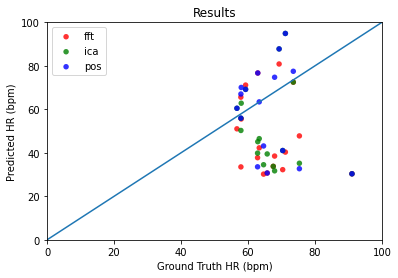

In [222]:
preds = (fft, ica, pos)
colors = ("red", "green", "blue")
groups = ("fft", "ica", "pos")

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.set(xlim=(0, 100), ylim=(0, 100))
ax.plot((0,100), (0,100))
plt.xlabel('Ground Truth HR (bpm)')
plt.ylabel('Predicted HR (bpm)')

for color,group,pred in zip(colors,groups,preds):
    ax.scatter(gt, pred, alpha=0.8, c=color, edgecolors='none', s=30, label=group)
    
plt.title('Results')
plt.legend(loc=2)
plt.show()

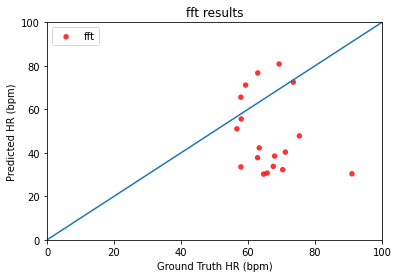

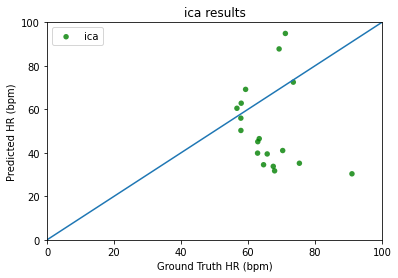

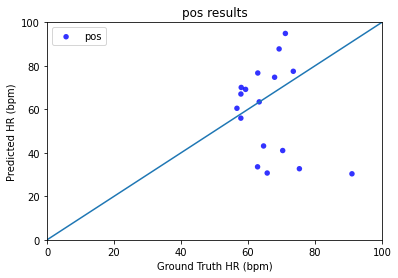

In [224]:
preds = (fft, ica, pos)
colors = ("red", "green", "blue")
groups = ("fft", "ica", "pos")

for color,group,pred in zip(colors,groups,preds):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.set(xlim=(0, 100), ylim=(0, 100))
    ax.plot((0,100), (0,100))
    plt.xlabel('Ground Truth HR (bpm)')
    plt.ylabel('Predicted HR (bpm)')
    ax.scatter(gt, pred, alpha=0.8, c=color, edgecolors='none', s=30, label=group)
    plt.title(group + " results")
    plt.legend(loc=2)
    plt.show()